In [1]:
from scipy.constants import c
from scipy.special import erf
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import emcee
import iminuit
from iminuit import Minuit
from scipy.stats import truncnorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import hypsecant
from scipy.stats import norm
from scipy.stats import laplace
from scipy.integrate import quad
from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.halo import mass_so
from colossus.halo import concentration

%load_ext cython

In [2]:
def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]    
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):
    """
INTERSECTIONS Intersections of curves.
   Computes the (x,y) locations where two curves intersect.  The curves
   can be broken with NaNs or have vertical segments.
usage:
x,y=intersection(x1,y1,x2,y2)
    Example:
    a, b = 1, 2
    phi = np.linspace(3, 10, 100)
    x1 = a*phi - b*np.sin(phi)
    y1 = a - b*np.cos(phi)
    x2=phi    
    y2=np.sin(phi)+2
    x,y=intersection(x1,y1,x2,y2)
    plt.plot(x1,y1,c='r')
    plt.plot(x2,y2,c='g')
    plt.plot(x,y,'*k')
    plt.show()
    """
    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]

Some function definitions:

* the model calls three different velocity dispersions, so it's cleaner to have a function for them
* the los distribution is a very cut-off gaussian, so renormalizing with erf is necessary
* the log likelihood, using flat priors whose limits are defined in a long 'if' statement.

In [3]:
df_full = pd.read_pickle('paxtons_cat_with_R200m.pkl')

In [4]:
G=4.301e-9 #km^2 Mpc Msolar^-1 s^-2
df_full['v_circ']=np.sqrt(G*df_full.M200m/df_full.R200m)

In [5]:
#df=df_full[ (df_full.r>=2.2*df_full.r_lambda) & (df_full.r<=5*df_full.r_lambda)].copy().reset_index(drop=True)
newdf=df_full

minr=2.0
maxr=4.0

mycut=1
mybgcut=2

dfcut=newdf[ (newdf.r/newdf.R200m>minr) & (newdf.r/newdf.R200m<=maxr) & (np.abs(newdf.v*100/newdf.v_circ)<=4)].copy()
dfcut=dfcut.reset_index()

In [6]:
def error(parameters):
    global v, mymin, mymax
    global vhist
    
    A_inf, A_los, sp_bg,sp_inf=parameters
    
    inf_dist = 1/np.pi/sp_inf/np.cosh(v/sp_inf)

    los_dist = truncnorm.pdf(v, -4, 4, 0, sp_bg)

    tot_dist = A_inf*inf_dist+A_los*los_dist
    
    ls=np.sum( (vhist - tot_dist)**2 )
    
    lp=0

    withinlimits=[]
    for i in range(len(parameters)):
        withinlimits=np.append( withinlimits, (mymin[i]<parameters[i]<mymax[i]))
    if np.all(withinlimits.astype(bool)):
        lp=0
    else:
        lp=np.inf
        
    return ls+lp

In [7]:
def nerror(parameters):
    return -error(parameters)

In [8]:
counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=100)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
normalized_counts = counts / len(dfcut.v) / width

In [9]:
vhist=normalized_counts
v = np.linspace(-4,4,len(vhist))

In [10]:
origin=[0.5,1,20,0.5]
mymin=[0,0,0,0]
mymax=[10,10,100,10]

In [11]:
error(origin)

0.1939059384080581

In [12]:
from scipy import optimize

sol=optimize.minimize(error, origin, method="Nelder-Mead")

In [13]:
sol.x

array([0.41736961, 1.09048894, 5.42546489, 0.43186452])

In [14]:
labels=['A_{da}','A_{los}','\sigma_{p,da}','\sigma_{p,los}']
bnds=[(x,y) for x, y in zip(mymin, mymax)]

In [15]:
error.errordef=1
m = Minuit(error, origin,name=labels)
m.limits = bnds
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.001827                   │              Nfcn = 92               │
│ EDM = 3.7e-05 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name           │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_{da}         │    0.4    │    1.1    │            │            │    0    │   10    │       │
│ 1 │ A_{los}        │     1     │     8     │            │            │    0    │   10    │       │
│ 2 │ \sigma_{p,da}  │     0     │    90     │            │            │    0    │   100   │       │
│ 3 │ \sigma_{p,los} │    0.4    │    1.0    │            │            │    0    │   10    │       │
└───┴────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────┬─────────────────────────────────────────────────────────────┐
│                │         A_{da}        A_{los}  \sigma_{p,da} \sigma_{p,los} │
├────────────────┼─────────────────────────────────────────────────────────────┤
│         A_{da} │           1.46           5.95           51.2           1.13 │
│        A_{los} │           5.95           61.8            420           4.16 │
│  \sigma_{p,da} │           51.2            420       3.05e+03           36.9 │
│ \sigma_{p,los} │           1.13           4.16           36.9           1.19 │
└────────────────┴─────────────────────────────────────────────────────────────┘

In [16]:
np.array(m.values)

array([0.40991917, 1.02460361, 4.95083684, 0.42605058])

Text(0.5, 0, '$R/R_{R200m}$')

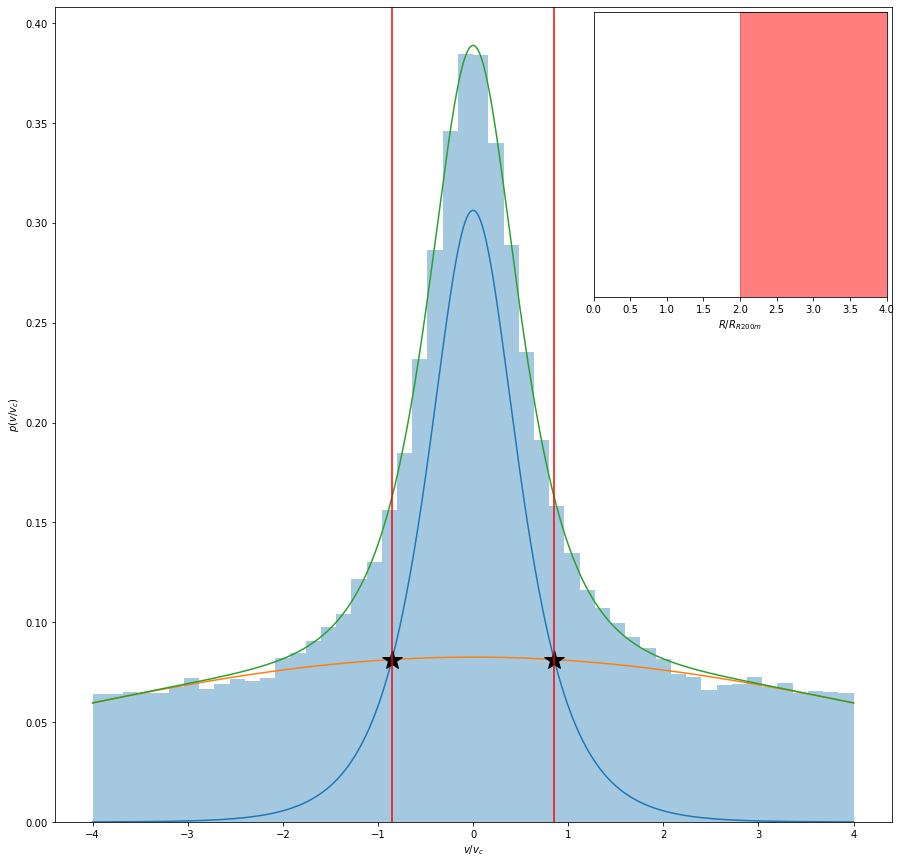

In [18]:
fig,(ax1) = plt.subplots(1,1,figsize=(15,15))

counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=50)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
normalized_counts = counts / len(dfcut.v) / width
ax1.bar(centers,normalized_counts,width=width,alpha=0.4)
x=np.linspace(-4,4,1000)

A_inf, A_los, sp_bg,sp_inf=np.array(m.values)

bg=truncnorm.pdf(x, -4, 4, 0, sp_bg)
mycosh=1/np.pi/sp_inf/np.cosh(x/sp_inf)
ax1.plot(x, A_inf*mycosh)
ax1.plot(x, A_los*bg)
ax1.plot(x, A_inf*mycosh+A_los*bg)

x,y=intersection(x,A_inf*mycosh,x,A_los*bg)
mycut=np.abs(x[0])
ax1.plot(x,y,'*k',markersize=20)
ax1.axvline(-mycut, c='r')
ax1.axvline(mycut, c='r')
ax1.set_xlabel('$v/v_c$')
ax1.set_ylabel('$p(v/v_c)$')
inset_ax = inset_axes(ax1,
                  height="35%", # set height
                  width="35%", # and width
                  loc='upper right')
inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
inset_ax.set_xlim(0,4)
inset_ax.set_yticks([])
inset_ax.set_xlabel('$R/R_{R200m}$')

In [19]:
radial_bins=np.linspace(0.2,4.8,30)
rbin_centers = (radial_bins[:-1] + radial_bins[1:])/2.
count=0
df=df_full

parameters=np.zeros( (len(radial_bins),len(origin)) )
errors=np.zeros( (len(radial_bins),len(origin)) )

In [20]:
for i in radial_bins:

    dfcut=df[ (df.r/df.R200m>i) & (df.r/df.R200m<=i+0.2) & (np.abs(df.v*100/df.v_circ)<=4)].copy()
    dfcut=dfcut.reset_index()
    
    #note these are globals being implicitly passed to the function
    counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=100)
    centers = (bins[:-1] + bins[1:])/2.
    width = bins[1] - bins[0]
    vhist = counts / len(dfcut.v) / width
    v = np.linspace(-4,4,len(vhist))
    
    error.errordef=1
    m = Minuit(error, origin,name=labels)
    m.limits = bnds
    m.migrad()
    
    parameters[count]=np.array(m.values)
    errors[count]=np.array(m.errors)
    print(i,i+0.2,parameters[count])
    count = count + 1

0.2 0.4 [ 0.96855984  0.17440979 11.34262919  0.59268931]
0.3586206896551724 0.5586206896551724 [ 0.93311073  0.26783185 10.53268827  0.55926942]
0.5172413793103448 0.7172413793103447 [0.8536868  0.42169384 8.10454534 0.5380767 ]
0.6758620689655173 0.8758620689655172 [ 0.79648657  0.86213299 12.99973841  0.52274664]
0.8344827586206895 1.0344827586206895 [0.72066912 0.85829207 9.19889194 0.50382199]
0.993103448275862 1.193103448275862 [0.64003468 0.86337547 7.10707119 0.46479637]
1.1517241379310343 1.3517241379310343 [0.61529765 1.01845535 7.98826753 0.49107937]
1.3103448275862066 1.5103448275862066 [0.58342143 1.17570844 8.60365887 0.47039279]
1.4689655172413791 1.668965517241379 [0.52575862 0.94496452 5.79913674 0.4310059 ]
1.6275862068965516 1.8275862068965516 [0.44866214 0.78877763 3.80532517 0.37995336]
1.786206896551724 1.9862068965517239 [0.44476789 0.81414019 3.9441671  0.38699124]
1.9448275862068962 2.144827586206896 [0.45698489 0.88510023 4.54658023 0.4164519 ]
2.1034482758620

In [119]:
def error2(parameters):
    global v, mymin, mymax
    global vhist, sp_bg
    
    A_inf, A_los,sp_inf=parameters
    
    inf_dist = 1/np.pi/sp_inf/np.cosh(v/sp_inf)

    los_dist = truncnorm.pdf(v, -4, 4, 0, sp_bg)

    tot_dist = A_inf*inf_dist+A_los*los_dist
    
    ls=np.sum( (vhist - tot_dist)**2 )
    
    lp=0

    withinlimits=[]
    for i in range(len(parameters)):
        withinlimits=np.append( withinlimits, (mymin[i]<parameters[i]<mymax[i]))
    if np.all(withinlimits.astype(bool)):
        lp=0
    else:
        lp=np.inf
        
    return ls+lp

In [120]:
def nerror2(parameters):
       
    return -error2(parameters)

In [121]:
origin=[0.5,0.5,0.5]
mymin=[0,0,0]
mymax=[1,1,1]

In [204]:
minr=1.0
maxr=1.2
sp_bg=6

dfcut=newdf[ (newdf.r/newdf.r_lambda>minr) & (newdf.r/newdf.r_lambda<=maxr) & (np.abs(newdf.v*100/newdf.v_circ)<=4)].copy()
dfcut=dfcut.reset_index()

counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=100)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
vhist = counts / len(dfcut.v) / width
v = np.linspace(-4,4,len(vhist))

In [205]:
error2(origin)

0.032451892440680814

In [206]:
sol=optimize.minimize(error2, origin, method="Nelder-Mead")

In [207]:
sol.x

array([0.79622281, 0.42954142, 0.52726433])

In [208]:
labels=['A_{da}','A_{los}','\sigma_{p,da}']
bnds=[(x,y) for x, y in zip(mymin, mymax)]

error2.errordef=1
m = Minuit(error2, origin,name=labels)
m.limits = bnds
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.01886                    │              Nfcn = 54               │
│ EDM = 4.47e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_{da}        │    0.8    │    0.9    │            │            │    0    │    1    │       │
│ 1 │ A_{los}       │    0.4    │    0.8    │            │            │    0    │    1    │       │
│ 2 │ \sigma_{p,da} │    0.5    │    0.7    │            │            │    0    │    1    │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬───────────────────────────────────────────┐
│               │        A_{da}       A_{los} \sigma_{p,da} │
├───────────────┼───────────────────────────────────────────┤
│        A_{da} │         0.844         -1.76         0.447 │
│       A_{los} │         -1.76          6.28        -0.921 │
│ \sigma_{p,da} │         0.447        -0.921         0.387 │
└───────────────┴───────────────────────────────────────────┘

In [209]:
np.array(m.values)

array([0.79129798, 0.44474552, 0.5257656 ])

In [210]:
np.array(m.errors)

array([0.89508119, 0.75389145, 0.74535079])

Text(0.5, 0, '$R/R_{R_{\\lambda}}$')

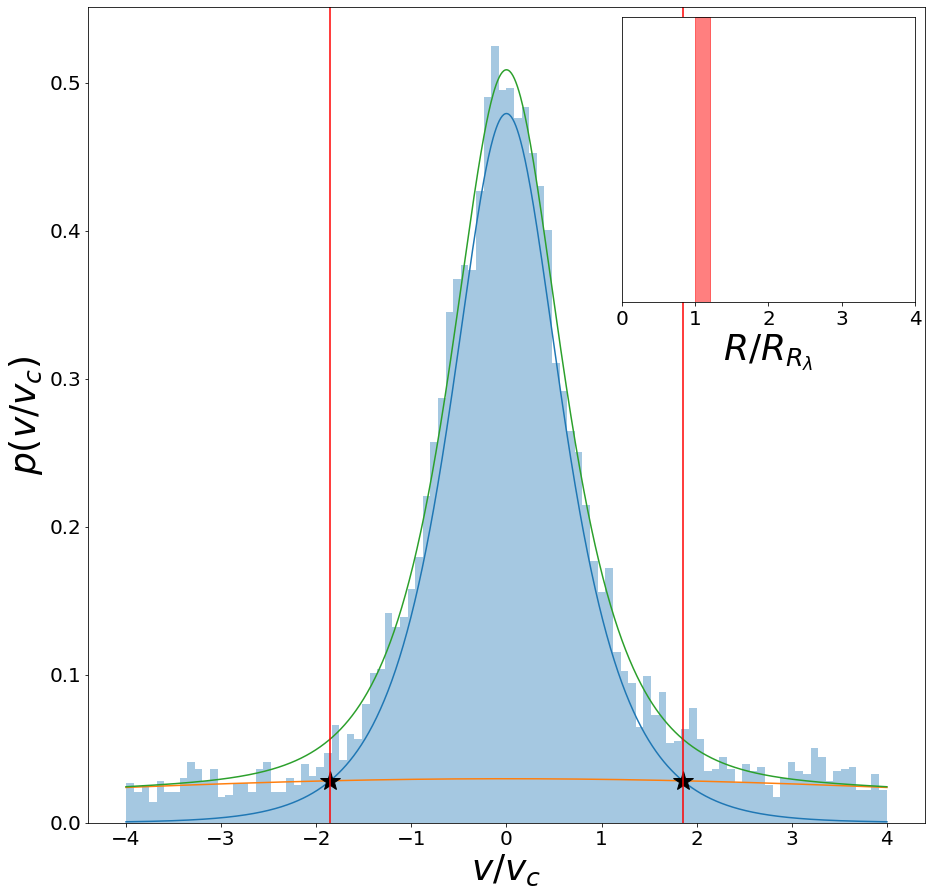

In [211]:
fig,(ax1) = plt.subplots(1,1,figsize=(15,15))

counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=100)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
normalized_counts = counts / len(dfcut.v) / width
ax1.bar(centers,normalized_counts,width=width,alpha=0.4)
x=np.linspace(-4,4,1000)

A_inf, A_los,sp_inf=np.array(m.values)
#A_inf, A_los,sp_inf=np.array(mcmc_best)
#A_inf, A_los,sp_inf=np.array([.635,.509,.574])
sp_bg=6

bg=truncnorm.pdf(x, -4, 4, 0, sp_bg)
mycosh=1/np.pi/sp_inf/np.cosh(x/sp_inf)

ax1.plot(x, A_inf*mycosh)
ax1.plot(x, A_los*bg)
ax1.plot(x, A_inf*mycosh+A_los*bg)

x,y=intersection(x,A_inf*mycosh,x,A_los*bg)
mycut=np.abs(x[0])
ax1.plot(x,y,'*k',markersize=20)
ax1.axvline(-mycut, c='r')
ax1.axvline(mycut, c='r')
ax1.set_xlabel('$v/v_c$')
ax1.set_ylabel('$p(v/v_c)$')
inset_ax = inset_axes(ax1,
                  height="35%", # set height
                  width="35%", # and width
                  loc='upper right')
inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
inset_ax.set_xlim(0,4)
inset_ax.set_yticks([])
inset_ax.set_xlabel('$R/R_{R_{\lambda}}$')

In [157]:
SMALL_SIZE = 20
MEDIUM_SIZE = 36
BIGGER_SIZE = 36

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

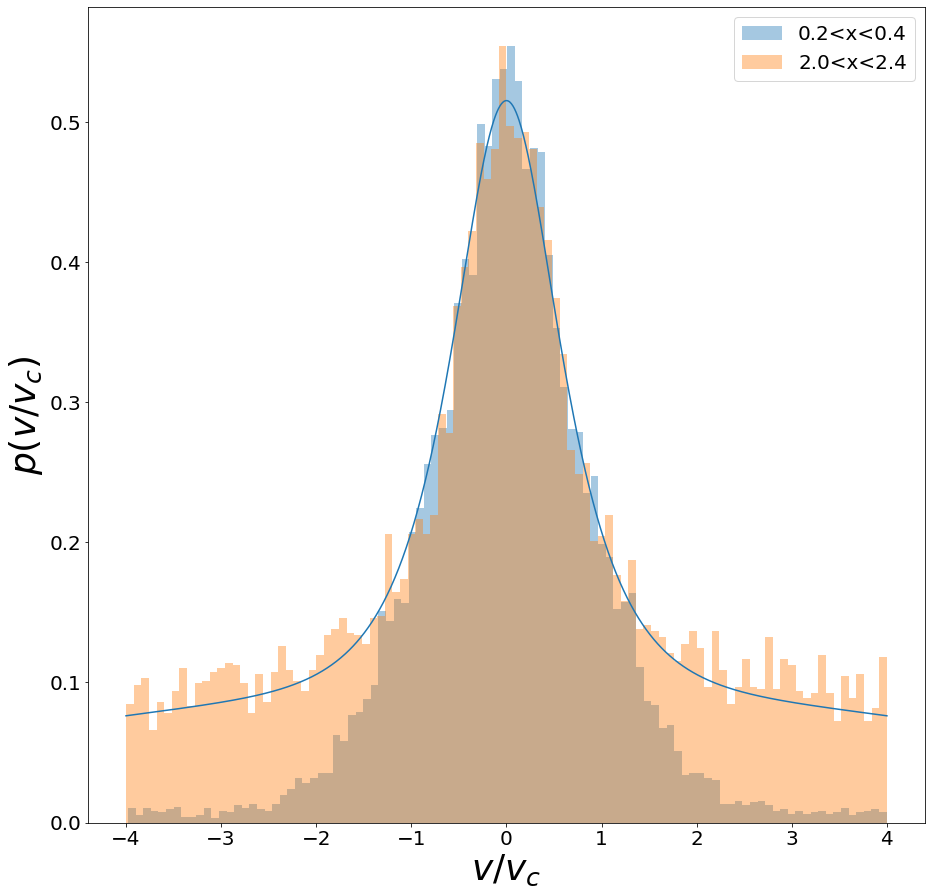

In [162]:
fig,(ax1) = plt.subplots(1,1,figsize=(15,15))

minr=0.2
maxr=0.4

dfcut=newdf[ (newdf.r/newdf.r_lambda>minr) & (newdf.r/newdf.r_lambda<=maxr) & (np.abs(newdf.v*100/newdf.v_circ)<=4)].copy()
dfcut=dfcut.reset_index()

counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=100)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
normalized_counts = counts / len(dfcut.v) / width
ax1.bar(centers,normalized_counts,width=width,alpha=0.4,label='0.2<x<0.4')

peak=np.max(normalized_counts)

minr=3.8
maxr=4.0

dfcut=newdf[ (newdf.r/newdf.r_lambda>minr) & (newdf.r/newdf.r_lambda<=maxr) & (np.abs(newdf.v*100/newdf.v_circ)<=4)].copy()
dfcut=dfcut.reset_index()

counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=100)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
normalized_counts = counts / len(dfcut.v) / width

peak2=np.max(normalized_counts)

ax1.bar(centers,normalized_counts*peak/peak2,width=width,alpha=0.4,label='2.0<x<2.4')

x=np.linspace(-4,4,1000)

A_inf, A_los,sp_inf=np.array(m.values)
sp_bg=6

bg=truncnorm.pdf(x, -4, 4, 0, sp_bg)
mycosh=1/np.pi/sp_inf/np.cosh(x/sp_inf)

#ax1.plot(x, A_inf*mycosh)
#ax1.plot(x, A_los*bg)
ax1.plot(x, (A_inf*mycosh+A_los*bg)*peak/peak2)

x,y=intersection(x,A_inf*mycosh,x,A_los*bg)
mycut=np.abs(x[0])
#ax1.plot(x,y,'*k',markersize=20)
#ax1.axvline(-mycut, c='r')
#ax1.axvline(mycut, c='r')
ax1.set_xlabel('$v/v_c$')
ax1.set_ylabel('$p(v/v_c)$')
ax1.legend()

In [178]:
radial_bins=np.linspace(0.2,5,30)
rbin_centers = (radial_bins[:-1] + radial_bins[1:])/2.
count=0
df=df_full

sp_bg=4

parameters=np.zeros( (len(radial_bins),len(origin)) )
errors=np.zeros( (len(radial_bins),len(origin)) )

In [185]:
A_inf=[]
A_los=[]
sp_inf=[]
sp_inf_e=[]

for i in range(len(radial_bins)):

    dfcut=df[ (df.r/df.r_lambda>radial_bins[i]-0.1) & (df.r/df.r_lambda<=radial_bins[i]+0.1) & (np.abs(df.v*100/df.v_circ)<=4)].copy()
    dfcut=dfcut.reset_index()
    
    #note these are globals being implicitly passed to the function
    counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=100)
    centers = (bins[:-1] + bins[1:])/2.
    width = bins[1] - bins[0]
    vhist = counts / len(dfcut.v) / width
    v = np.linspace(-4,4,len(vhist))
    
    error2.errordef=1.0
    m = Minuit(error2, origin,name=labels)
    m.limits = bnds
    m.migrad()
    
    A_inf=np.append(A_inf,np.array(m.values)[0])
    A_los=np.append(A_los,np.array(m.values)[0])
    sp_inf=np.append(sp_inf,np.array(m.values)[2])
    sp_inf_e=np.append(sp_inf_e,np.array(m.errors)[2])
    print(radial_bins[i]-0.1,radial_bins[i]+0.1,np.array(m.values), np.array(m.errors))

0.1 0.30000000000000004 [0.99631273 0.02474    0.61716544] [0.88826129 0.98454201 0.7504756 ]
0.2655172413793103 0.4655172413793104 [0.97212787 0.05554962 0.59882479] [0.61104349 0.97166891 0.78107211]
0.43103448275862066 0.6310344827586206 [0.94873494 0.0864808  0.58623187] [0.56030462 0.50231028 0.77069927]
0.5965517241379311 0.7965517241379311 [0.89335885 0.16437889 0.54153547] [0.86037408 0.68649168 0.74697685]
0.7620689655172413 0.9620689655172413 [0.8373543  0.24674118 0.52641935] [0.90133374 0.86023268 0.74230927]
0.9275862068965518 1.1275862068965519 [0.78497105 0.32398393 0.51793808] [0.8872804  0.83268169 0.74436022]
1.093103448275862 1.293103448275862 [0.75024675 0.37803987 0.49803966] [0.87414527 0.77475832 0.73640986]
1.2586206896551724 1.4586206896551726 [0.69123801 0.46404478 0.4703331 ] [0.845619   0.67019099 0.72620331]
1.4241379310344826 1.6241379310344828 [0.64651758 0.5271912  0.4789283 ] [0.82323772 0.6009889  0.73333621]
1.5896551724137928 1.789655172413793 [0.587

In [189]:
from scipy import optimize

In [192]:
def piecewise_linear(x, x0, y0, k1):
#    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:y0])

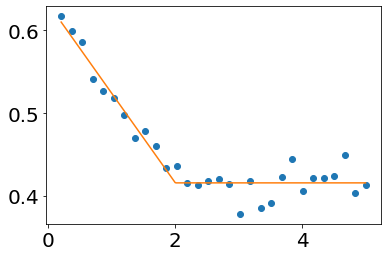

In [193]:
x=radial_bins
y=sp_inf
p , e = optimize.curve_fit(piecewise_linear, x, y)
xd=np.linspace(0.2,5,300)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

Text(0.5, 0, 'R/$R_\\lambda$')

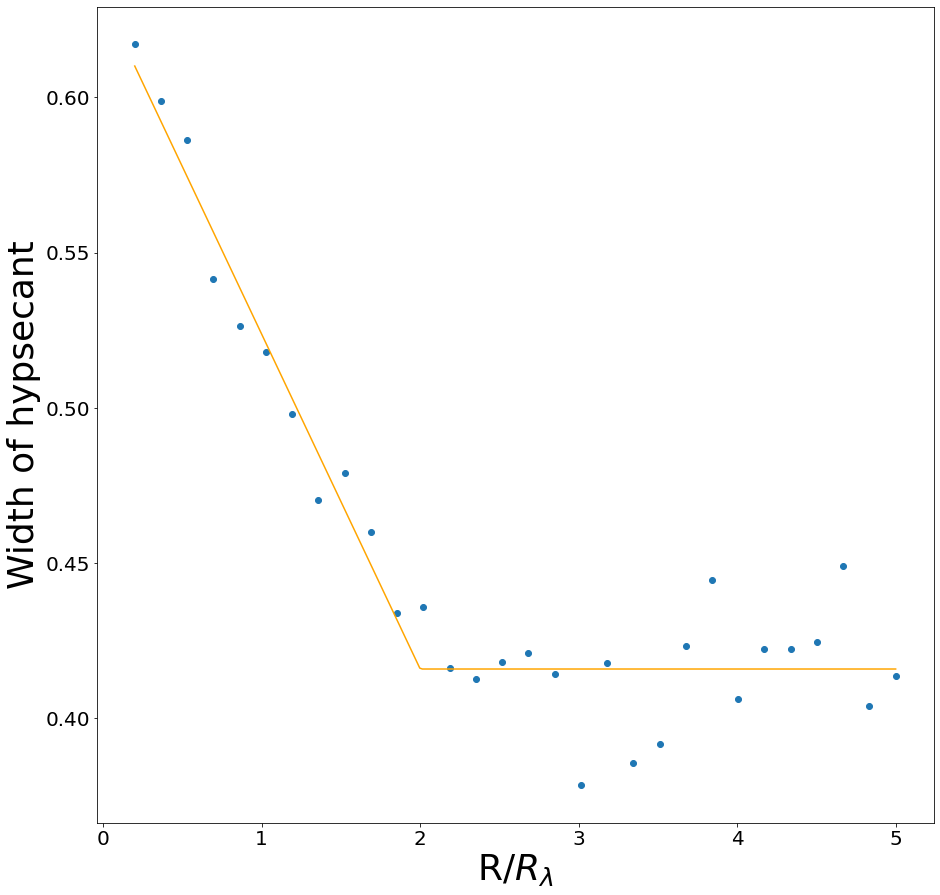

In [195]:
fig,(ax1) = plt.subplots(1,1,figsize=(15,15))

ax1.scatter(radial_bins,sp_inf)
ax1.plot(xd, piecewise_linear(xd, *p),color='orange')
ax1.set_ylabel('Width of hypsecant')
ax1.set_xlabel('R/$R_\lambda$')

In [276]:
dfcut=df[ (df.r/df.r_lambda>i) & (df.r/df.r_lambda<=i+0.2) & (np.abs(df.v*100/df.v_circ)<=4)].copy()
dfcut=dfcut.reset_index()

#note these are globals being implicitly passed to the function
counts, bins = np.histogram(dfcut.v*100/dfcut.v_circ, bins=2000)
centers = (bins[:-1] + bins[1:])/2.
width = bins[1] - bins[0]
vhist = counts / len(dfcut.v) / width
v = np.linspace(-4,4,len(vhist))

error2.errordef=1
m = Minuit(error2, origin,name=labels)
m.limits = bnds
m.migrad()

A_inf=np.append(A_inf,np.array(m.values)[0])
A_los=np.append(A_los,np.array(m.values)[0])
sp_inf=np.append(sp_inf,np.array(m.values)[2])
sp_inf_e=np.append(sp_inf_e,np.array(m.errors)[2])
print(i,i+0.2,np.array(m.values))
count = count + 1

4.0 4.2 [0.40491509 1.55643648 0.42988918]


In [309]:
radial_bins=np.linspace(0.2,5,30)
rbin_centers = (radial_bins[:-1] + radial_bins[1:])/2.
count=0
df=df_full
sp_inf=[]

In [333]:
sp_inf=[]

for i in radial_bins:

    dfcut=df[ (df.r/df.r_lambda>i) & (df.r/df.r_lambda<=i+0.2) & (np.abs(df.v*100/df.v_circ)<=1)].copy()
    dfcut=dfcut.reset_index()
    sp_inf=np.append(sp_inf,np.std(dfcut.v))
    

Text(0.5, 0, 'R/$R_\\lambda$')

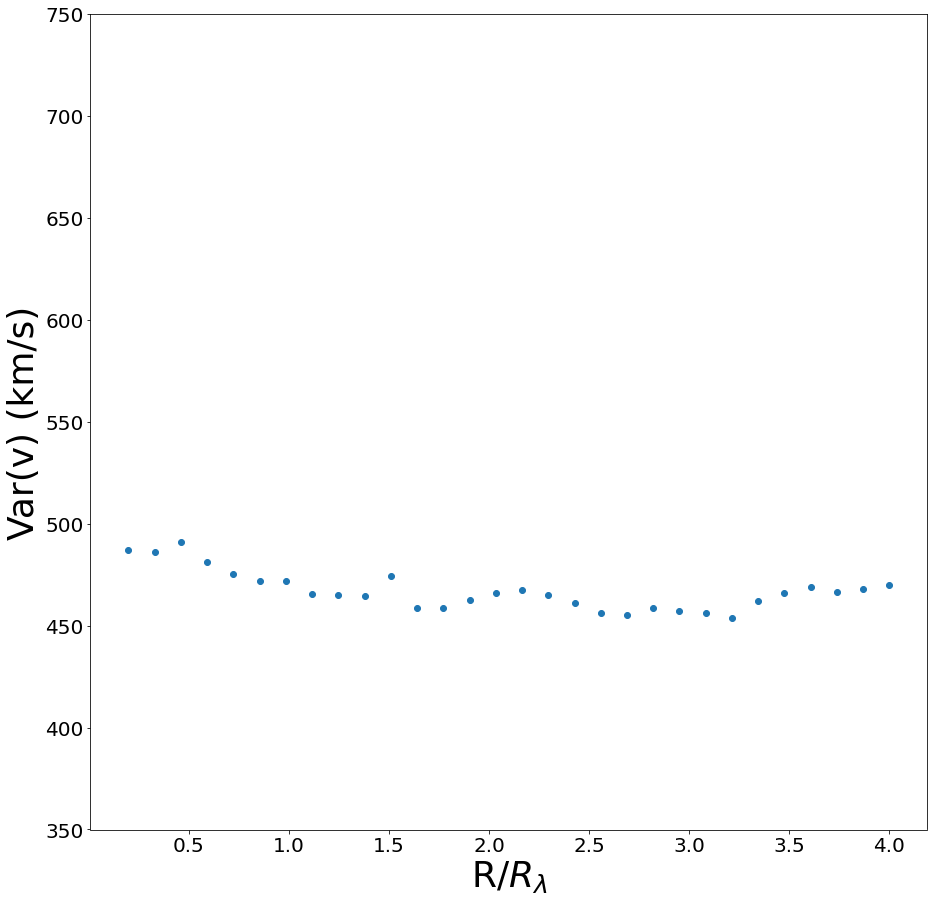

In [334]:
fig,(ax1) = plt.subplots(1,1,figsize=(15,15))

ax1.scatter(radial_bins,sp_inf*100)
ax1.set_ylim([350,750])
ax1.set_ylabel('Var(v) (km/s)')
ax1.set_xlabel('R/$R_\lambda$')